In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import copy
from hendrics.fake import filter_for_deadtime
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum, AveragedCrossspectrum

from astropy.modeling.models import Lorentz1D, Const1D
import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack
from scipy.interpolate import interp1d
from stingray.utils import rebin_data_log
from stingray.gti import bin_intervals_from_gtis
from hendrics.base import r_in, r_det
from stingray.modeling.posterior import GaussianLogLikelihood
from stingray.modeling.parameterestimation import ParameterEstimation
import os
import glob

from stingray.utils import rebin_data

np.random.seed(348172694)

from stingray import Lightcurve, Crossspectrum
from stingray.simulator.simulator import Simulator
from scipy.ndimage.filters import gaussian_filter1d

## What about different fluxes?

In [2]:
from hendrics.io import load_events, load_lcurve, load_pds, save_lcurve, save_pds
from stingray.gti import cross_two_gtis
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum, AveragedCrossspectrum

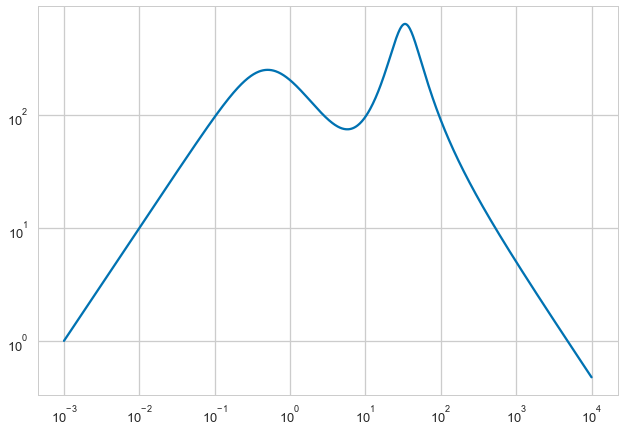

In [3]:
model = Lorentz1D(x_0=0, fwhm=1, amplitude=1000) + \
        Lorentz1D(x_0=30, fwhm=30, amplitude=20)

freqs = np.logspace(-3, 4, 1000)
plt.figure()
plt.loglog(freqs, model(freqs) * freqs)

In [4]:
from astropy.modeling.models import Lorentz1D
from stingray.events import EventList

def create_model_lightcurve(model, tstart=0, tstop=8192, dt=1/512, 
                            mean_ctrate=200, rms=0.25): 

    time = np.arange(tstart, tstop, dt)

    # The current normalization is not precise for very high count rates!
    sim = Simulator(N=len(time), dt=dt, rms=1, 
                    mean=10000, red_noise=3)
    sim_lc_clean = sim.simulate(model)

    # Correct normalization
    sim_lc_clean.counts -= np.mean(sim_lc_clean.counts)
    factor = rms / np.std(sim_lc_clean.counts)
    sim_lc_clean.counts *= factor
    sim_lc_clean.counts += 1
    sim_lc_clean.counts *= mean_ctrate
    
    sim_lc_clean.counts *= dt

    return sim_lc_clean


In [5]:
def create_event_lists_from_lightcurve(lc_in, channel_ratio=1):
    # work on a copy, not on the original light curve
    lc = copy.deepcopy(lc_in)
    events = EventList()
    events.simulate_times(lc)
    event_times1 = events.time

    lc.counts *= channel_ratio
    events.simulate_times(lc)
    event_times2 = events.time
    return event_times1, event_times2

def create_lightcurve_with_deadtime(event_times, dt, tstart=0, tstop=8192, 
                                    deadtime=2.5e-3):
    gti = [[tstart, tstop]]
    lc_clean = Lightcurve.make_lightcurve(event_times, 
                                          gti=gti, 
                                          tstart=tstart, tseg=tstop - tstart,
                                          dt=dt)
    events_dt = filter_for_deadtime(event_times, deadtime)
    lc = Lightcurve.make_lightcurve(events_dt, 
                                    gti=gti, 
                                    tstart=tstart, tseg=tstop - tstart,
                                    dt=dt)
    return lc_clean, lc

   
def create_lightcurves_with_deadtime(lc_in, channel_ratio=1, 
                                     lc_dt=1/2048, deadtime=2.5e-3):
    
    event_times1, event_times2 = \
        create_event_lists_from_lightcurve(lc_in, channel_ratio=channel_ratio)

    lc1_clean, lc1 = \
        create_lightcurve_with_deadtime(event_times1, lc_dt, 
                                        tstart=lc_in.tstart, 
                                        tstop=lc_in.tseg - lc_in.tstart,
                                        deadtime=deadtime)
    lc2_clean, lc2 = \
        create_lightcurve_with_deadtime(event_times2, lc_dt, 
                                        tstart=lc_in.tstart, 
                                        tstop=lc_in.tseg - lc_in.tstart,
                                        deadtime=deadtime)

    return lc1_clean, lc1, lc2_clean, lc2

def calculate_and_save_freq_spectrum(lc1, lc2=None, segment_size=512, 
                                     file_name=None, norm='frac'):
    if lc2 is None:
        pds = AveragedPowerspectrum(lc1, segment_size=segment_size, 
                                    norm=norm)
        if file_name is None:
            file_name = 'pds.nc'
    else:
        pds = AveragedCrossspectrum(lc1, lc2, 
                                    segment_size=segment_size, 
                                    norm=norm)
        if file_name is None:
            file_name = 'cpds.nc'

#     print('Saving ' + file_name)
    save_pds(pds, file_name, save_all=False)

    return file_name

def modify_saved_power(in_file_name, new_power, meancounts=None, 
                       out_file_name=None):
    
    if out_file_name is None:
        out_file_name = in_file_name.replace('.nc', '_out.nc')
    newpow = load_pds(in_file_name)

    newpow.norm = 'none'
    newpow.power = new_power
    if meancounts is not None:
        newpow.power = newpow.power / newpow.n**2 
        newpow.power = newpow.power * 2 * newpow.segment_size / meancounts **2

#     print('Saving ' + out_file_name)
    save_pds(newpow, out_file_name)


In [36]:
def calculate_fad_and_save_all_spectra(lc1, lc2, file_label='all_',
                                       segment_size=512, 
                                       smoothing_alg='gauss', 
                                       smoothing_length=None):
    from fad_correction import FAD_power_spectra

    results = \
        FAD_power_spectra(lc1, lc2, segment_size=segment_size, smoothing_alg=smoothing_alg, 
                          smoothing_length=smoothing_length)

    freqs = results.freq
    pds1_norm = results.pds1
    pds2_norm = results.pds2
    crosssp_norm = results.cs
    ptot_norm = results.ptot
    is_compliant = results.is_compliant
    fad_delta = results.fad_delta

#     print('Fourier Amplitudes loaded')
    calculate_and_save_freq_spectrum(lc1, segment_size=segment_size, 
                                     file_name=file_label + 'pds1_dt.nc')
    calculate_and_save_freq_spectrum(lc2, segment_size=segment_size, 
                                     file_name=file_label + 'pds2_dt.nc')
    modify_saved_power(file_label + 'pds1_dt.nc', ptot_norm, lc1.meancounts + lc2.meancounts, 
                       out_file_name=file_label + 'pdstot_norm.nc')
    modify_saved_power(file_label + 'pds1_dt.nc', pds1_norm, lc1.meancounts, 
                       out_file_name=file_label + 'pds1_norm.nc')
    calculate_and_save_freq_spectrum(lc1, lc2, segment_size=segment_size, 
                                     file_name=file_label + 'cs_dt.nc')
    modify_saved_power(file_label + 'pds1_dt.nc', crosssp_norm, (lc1.meancounts + lc2.meancounts) / 2, 
                       out_file_name=file_label + 'cs_norm.nc')
    return fad_delta

In [7]:
def load_rebinned(file, rebin_factor, kind='lin'):
    periodogram = load_pds(file)
    if kind == 'lin' and isinstance(rebin_factor, int):
        return periodogram.rebin(f=rebin_factor)
    elif kind == 'lin':
        return periodogram.rebin(df=rebin_factor)
    else:
        return periodogram.rebin_log(rebin_factor)
    

In [37]:
def simulate_spectrum(model, channel_ratio=1, rebin_factor=0.02, segment_size=512,
                      label=None, tstart = 0, tstop = 8192, smoothing_alg='gauss',
                      smoothing_length=None, rms=0.25, mean_ctrate=200):
    

    sim_lc = create_model_lightcurve(model, tstart, tstop, rms=rms,
                                     mean_ctrate=mean_ctrate)
    lc1_clean, lc1, lc2_clean, lc2 = \
        create_lightcurves_with_deadtime(sim_lc, 
                                         channel_ratio=channel_ratio, 
                                         lc_dt=1/2048, deadtime=2.5e-3)
    if label is None:
        label = '{:.2f}'.format(channel_ratio * 100)
    calculate_and_save_freq_spectrum(lc1_clean, segment_size=segment_size, 
                                     file_name=label + 'pds1_clean.nc')

    calculate_and_save_freq_spectrum(lc1_clean, lc2_clean, segment_size=segment_size, 
                                     file_name=label + 'cs_clean.nc')
    
    fad_delta = \
        calculate_fad_and_save_all_spectra(lc1, lc2, file_label=label, 
                                           segment_size=segment_size,
                                           smoothing_alg=smoothing_alg, 
                                           smoothing_length=smoothing_length)
    return label, fad_delta


In [38]:
label, fad_delta = \
    simulate_spectrum(model, tstop=1024, segment_size=512, smoothing_alg='gauss')

In [10]:
def plot_spectrum(file_label, rebin_factor=0.02, step=0.,
                  white_fmin=0, white_fmax=2048, xlim=None, ylim=None):
    cs_dt_reb = load_rebinned(file_label + 'cs_dt.nc', rebin_factor)
    cs_norm_reb = load_rebinned(file_label + 'cs_norm.nc', rebin_factor)
    pds_norm_reb = load_rebinned(file_label + 'pds1_norm.nc', rebin_factor)
    pdstot_norm_reb = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor)
    pds1_dt_reb = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor)
    
    lw=2
    good = (pds1_dt_reb.freq >= white_fmin)&(pds1_dt_reb.freq < white_fmax)
    fig = plt.figure()
    plt.plot(pds1_dt_reb.freq, pds1_dt_reb.power - np.mean(pds1_dt_reb.power[good]), 
             label='PDS 1', drawstyle='steps-mid', zorder=10, lw=lw)
    plt.plot(pds_norm_reb.freq, pds_norm_reb.power - np.mean(pds_norm_reb.power[good]) + step, 
             label='PDS 1, FAD-normalized', drawstyle='steps-mid', lw=lw, color='r')
    plt.plot(pdstot_norm_reb.freq, pdstot_norm_reb.power - np.mean(pdstot_norm_reb.power[good]) + 2*step, 
             label='PDS 1+2, FAD-normalized', drawstyle='steps-mid', lw=lw, color='b')
    plt.plot(cs_dt_reb.freq, cs_dt_reb.power + 3 * step, 
             label='Cospectrum', drawstyle='steps-mid', lw=lw, color='grey')
    plt.plot(cs_norm_reb.freq, cs_norm_reb.power + 4 * step, 
             label='Cospectrum, FAD-normalized', drawstyle='steps-mid', lw=lw, color='k')
    plt.legend(loc=1)

    if step > 0:
        for i in range(4):
            plt.axhline(step * i, ls = '--', color='k', zorder=20)

    plt.xlim(xlim)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

    plt.savefig(file_label + 'rebin.jpg')
    plt.close(fig)

def plot_spectrum_log(file_label, rebin_factor=0.02, step=0.,
                      white_fmin=0, white_fmax=2048, xlim=None, ylim=None):
    cs_dt_reb_log = load_rebinned(file_label + 'cs_dt.nc', rebin_factor, kind='log')
    cs_norm_reb_log = load_rebinned(file_label + 'cs_norm.nc', rebin_factor, kind='log')
    pds_norm_reb_log = load_rebinned(file_label + 'pds1_norm.nc', rebin_factor, kind='log')
    pdstot_norm_reb_log = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor, kind='log')
    pds1_dt_reb_log = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor, kind='log')
    lw=2
    fig, ax1 = plt.subplots()

    ax1.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_reb_log.power, 
             label='Cospectrum', 
             lw=lw, drawstyle='steps-mid', color='grey', zorder=3)

    ax1.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_reb_log.power, 
             label='Cospectrum, FAD-normalized', 
             lw=lw, drawstyle='steps-mid', color='k')

    good = (pds1_dt_reb_log.freq >= white_fmin)&(pds1_dt_reb_log.freq < white_fmax)

    lev = np.mean(pds_norm_reb_log.power.real[good])
    ax1.plot(pds_norm_reb_log.freq,
             pds_norm_reb_log.freq*(pds_norm_reb_log.power - lev), 
             alpha=0.6, label='PDS 1, FAD-normalized', 
             lw=lw, drawstyle='steps-mid', color='r')

    lev = np.mean(pdstot_norm_reb_log.power.real[good])
    ax1.plot(pdstot_norm_reb_log.freq, 
             pdstot_norm_reb_log.freq*(pdstot_norm_reb_log.power - lev), 
             alpha=0.6, label='PDS 1, FAD-normalized', 
             lw=lw, drawstyle='steps-mid', color='b')

    ax1.legend()
    ax1.set_yscale('log', nonposy='clip')

    ax1.set_xscale('log', nonposx='clip')

    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)

    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel(r'${(\rm rms/mean)}^2$')

    plt.savefig(file_label + 'rebin_log.jpg')
    plt.close(fig)

In [11]:
plot_spectrum_log('100.00', rebin_factor=0.02, step=0., xlim=None, ylim=None)

In [93]:
def model_amp(model):
    amp1 = 0
    for mo in model:
        if 'x_0' not in mo.param_names:
            continue
        amp1 += mo.amplitude
    return amp1
    
def model_ratio(model1, model2):
    amp1 = model_amp(model1)
    amp2 = model_amp(model2)
    return amp1 / amp2

def model_delta_rms(model1, model2):
    amp1 = model_amp(model1)
    amp2 = model_amp(model2)

    return (amp1**0.5 - amp2**0.5) / amp2**0.5

def fit_model_to_spectrum(filename, model, rebin_factor=0.02, label='PDS',
                          fmin=0, fmax=2048, fig=None, color='k', lock_freqs=True):
    
    if lock_freqs:
        for mo in model:
            if 'x_0' not in mo.param_names:
                continue
            mo.x_0.fixed = True
            mo.fwhm.fixed = True

    spectrum = load_rebinned(filename, rebin_factor)
    maxmodel = np.max(model(spectrum.freq))
    maxspec = np.max(spectrum.power)
    ratio = maxspec/maxmodel
    for comp in model:
        comp.amplitude *= ratio

    good = (spectrum.freq < fmax)&(spectrum.freq >=fmin)

    lpost = GaussianLogLikelihood(spectrum.freq[good], spectrum.power[good], 
                                  np.sqrt(2/spectrum.m), copy.deepcopy(model))

    parest = ParameterEstimation()
    free_parameters = [getattr(model, par).value 
                       for par in model.param_names if not model.fixed[par]]

    res = parest.fit(lpost, free_parameters)
    if fig is not None:
        plot_fit_results(filename, res.model, label=label, fig=fig, color=color)
    return parest, res
    
def plot_fit_results(file, model, label='PDS', rebin_factor=0.02, ylim=None,
                     fig=None, color='k'):
    spectrum_log = load_rebinned(file, rebin_factor, kind='log')
    spectrum = load_rebinned(file, rebin_factor, kind='lin')
    freqs = spectrum.freq
    freqs_log = spectrum_log.freq
    
    offset = 0
    # If last model is a constant, not a Lorentzian
    if 'x_0' not in model[-1].param_names:
        offset = model[-1].amplitude

    powers = spectrum.power - offset
    powers_log = spectrum_log.power - offset
  
    lw=2
    closefig= False
    if fig is None:
        fig = plt.figure()
        closefig = True
    plt.plot(freqs, freqs*(model(freqs) - offset), color=color)
    for mo in model:
        if 'x_0' not in mo.param_names:
            continue
        plt.plot(freqs, freqs*mo(freqs), ls='--', color=color, lw=0.5)

    plt.plot(freqs_log, freqs_log * powers_log, 
             label=label, drawstyle='steps-mid', 
             lw=lw, zorder=3, color=color)

    plt.gca().set_yscale('log', nonposy='clip')
    plt.gca().set_xscale('log', nonposx='clip')

    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'${(\rm rms/mean)}^2$')
    if ylim is None:
        ylim = [1e-6, 0.5]
    plt.ylim(ylim)
    if closefig:
        plt.savefig(file.replace('.nc', '.jpg'))
        plt.close(fig)
    
def fit_model_to_all_data(file_label, model, rebin_factor=0.02, fmin=0, fmax=2048,
                          plot=True, print_results=True, fit_ref='cs'):
    from stingray.modeling import fit_powerspectrum
    
    model_cs = copy.deepcopy(model)
    model_pds = copy.deepcopy(model) + Const1D(0)    
    
    if plot:
        fig = plt.figure(file_label)
    else:
        fig = None

    pds_clean_parest, pds_clean_res = \
        fit_model_to_spectrum(file_label + 'pds1_clean.nc', model_pds,
                              label='Clean PDS 1', fig=fig, color='k',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)

    cs_clean_parest, cs_clean_res = \
        fit_model_to_spectrum(file_label + 'cs_clean.nc', model_cs,
                              label='Clean Cospectrum', fig=fig, color='#0000ff',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)
        
    if fit_ref == 'pds':
        fit_ref_parest, fit_ref_res = pds_clean_parest, pds_clean_res
    elif fit_ref == 'cs':
        fit_ref_parest, fit_ref_res = cs_clean_parest, cs_clean_res

    cs_dt_parest, cs_dt_res = \
        fit_model_to_spectrum(file_label + 'cs_dt.nc', model_cs,
                              label='Cospectrum', fig=fig, 
                              color='#aaaaff',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)
    cs_norm_parest, cs_norm_res = \
        fit_model_to_spectrum(file_label + 'cs_norm.nc', model_cs, 
                              label='FAD-normalized Cospectrum', fig=fig, 
                              color='#5555ff',
                              rebin_factor=rebin_factor,fmin=fmin, fmax=fmax)
    pds_norm_parest, pds_norm_res = \
        fit_model_to_spectrum(file_label + 'pds1_norm.nc', model_pds, 
                              label='FAD-normalized PDS 1', fig=fig, 
                              color='#aaaaaa',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)
    pdstot_norm_parest, pdstot_norm_res = \
        fit_model_to_spectrum(file_label + 'pdstot_norm.nc', model_pds, 
                              label='FAD-normalized total PDS', fig=fig,
                              color='#555555',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)
    
    spectrum = load_rebinned(file_label + 'pds1_clean.nc', rebin_factor)
    meanrate_clean = spectrum.nphots/spectrum.segment_size
    spectrum = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor)
    meanrate = spectrum.nphots/spectrum.segment_size

    expected_gain = r_in(2.5e-3, meanrate)/meanrate
    gain_cs = model_ratio(cs_norm_res.model, cs_dt_res.model)**0.5
    
    delta_cs = model_delta_rms(cs_norm_res.model, fit_ref_res.model)
    delta_cs_clean = model_delta_rms(cs_clean_res.model, pds_clean_res.model)

    gain_pds_norm = model_ratio(pds_norm_res.model, cs_dt_res.model)**0.5

    delta_pds = model_delta_rms(pds_norm_res.model, fit_ref_res.model)

    gain_pds_clean = model_ratio(pds_clean_res.model, cs_dt_res.model)**0.5


    gain_pdstot_norm = model_ratio(pdstot_norm_res.model, cs_dt_res.model)**0.5
    delta_pdstot = model_delta_rms(pdstot_norm_res.model, fit_ref_res.model)

    if plot:
        plt.legend()
        plt.savefig(file_label + 'all_fit.jpg')
    
    if print_results:
        print('Estimated:', meanrate, r_in(2.5e-3, meanrate), 'Ratio:', expected_gain)
        print('Real: ', meanrate, meanrate_clean, 'Ratio:', meanrate_clean / meanrate)

        print("Measured frac. rms from clean spectrum: {:.2f}%".format(
              model_amp(fit_ref_res.model)**0.5 * 100))

        print("Measured frac. rms from fad-corrected cs: {:.2f}%".format(
              model_amp(cs_norm_res.model)**0.5 * 100))

        print("Measured frac. rms from fad-corrected total pds: {:.2f}%".format(
              model_amp(pdstot_norm_res.model)**0.5 * 100))

        print("Measured frac. rms from fad-corrected single pds: {:.2f}%".format(
              model_amp(pds_norm_res.model)**0.5 * 100))

        print("Measured frac. rms from deadtime-affected cs: {:.2f}%".format(
              model_amp(cs_dt_res.model)**0.5 * 100))


        print("rms gain expected from incident/detected "
              "ratio: {:.2f}".format(expected_gain))

        print("rms gain cs_norm/cs_dt: "
              "{:.2f} (correct to {:.1f}%)".format(gain_cs,
                                               ((gain_cs - expected_gain) / expected_gain) * 100))

        print("rms gain pds_norm/cs_dt: "
              "{:.2f} (correct to {:.1f}%)".format(gain_pds_norm,
                                               ((gain_pds_norm - expected_gain) / expected_gain) * 100))

        print("rms gain pds_clean/cs_dt: "
              "{:.2f} (correct to {:.1f}%)".format(gain_pds_clean,
                                                   ((gain_pds_clean - expected_gain) / expected_gain) * 100))

        print("rms gain pdstot_norm/cs_dt: "
              "{:.2f} (correct to {:.1f}%)".format(gain_pdstot_norm,
                                              ((gain_pdstot_norm - expected_gain) / expected_gain) * 100))

    deltas = {'delta clean': delta_cs_clean, 'CS': delta_cs, 'PDS': delta_pds, 
              'PDStot': delta_pdstot, 'Frac_rms': model_amp(fit_ref_res.model)**0.5}
    return deltas

Estimated: 130.973632812 194.737243314 Ratio: 1.48684310829
Real:  130.973632812 199.208984375 Ratio: 1.52098540826
Measured frac. rms from clean spectrum: 20.18%
Measured frac. rms from fad-corrected cs: 21.07%
Measured frac. rms from fad-corrected total pds: 20.94%
Measured frac. rms from fad-corrected single pds: 20.86%
Measured frac. rms from deadtime-affected cs: 14.03%
rms gain expected from incident/detected ratio: 1.49
rms gain cs_norm/cs_dt: 1.50 (correct to 1.0%)
rms gain pds_norm/cs_dt: 1.49 (correct to -0.0%)
rms gain pds_clean/cs_dt: 1.45 (correct to -2.7%)
rms gain pdstot_norm/cs_dt: 1.49 (correct to 0.4%)


{'CS': 0.044294174327797108,
 'PDS': 0.033653579957135894,
 'PDStot': 0.037705690205537185,
 'delta clean': -0.0060766387786594803}

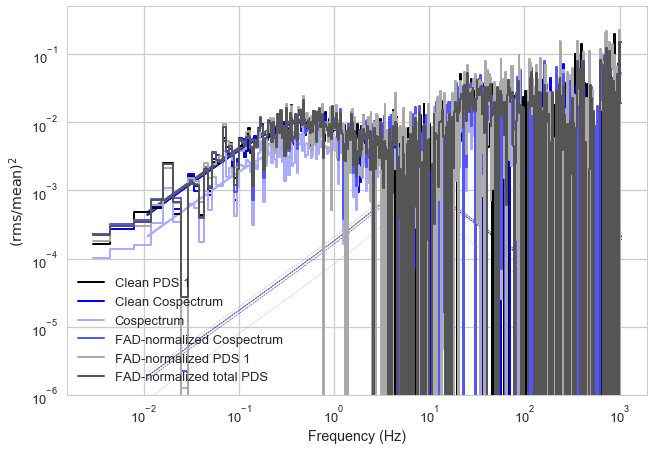

In [13]:
fit_model_to_all_data('100.00', model)

## And now, some statistics.

In [94]:
from astropy.table import Table
import shutil

def map_fad_gain_with_channel_ratio(model, N, table_file=None, 
                                    smoothing_alg='gauss', fit_ref='pds'):
    try:
        table = Table.read(table_file)
    except:
        table = Table(names=('fad_delta,channel_ratio,incident_rate,length,'
                             'segment size,fit_ref,flux_correction,smoothing,'
                             'smoothing length,delta clean,CS,PDS 1,PDStot,Frac_rms').split(','),
                      dtype=[float, float, float, float, float, 'S6', bool, 'S6', 
                             float, float, float, float, float, float])
        ,
    for i in range(N):
        channel_ratio = np.random.uniform(0.5, 2)
        mean_ctrate = np.random.uniform(100, 1000)
        length = np.random.choice(2**np.arange(10, 12))
        segment_size = np.random.choice(2**np.arange(6, 10))
        if segment_size >= length:
            continue
        rms = np.random.uniform(0.1, 0.4)
        smoothing_length = np.random.randint(5, 7) * segment_size.astype(np.int64)

        label, fad_delta = \
            simulate_spectrum(model, tstop=length, segment_size=512, 
                              channel_ratio=channel_ratio, rms=rms,
                              smoothing_alg=smoothing_alg, 
                              smoothing_length=smoothing_length,
                              mean_ctrate=mean_ctrate)
        deltas = fit_model_to_all_data(label, model, plot=False, 
                                       print_results=False, fmin=0, fmax=512,
                                       fit_ref=fit_ref)
        table.add_row([fad_delta, channel_ratio, mean_ctrate, length, 
                       segment_size, fit_ref, False, smoothing_alg, 
                       smoothing_length, deltas['delta clean'], 
                       deltas['CS'], deltas['PDS'], deltas['PDStot'],
                       deltas['Frac_rms']])
        for file in glob.glob(label + '*.nc'):
            os.unlink(file)
            pdsdir = file.replace('.nc', '')
            if os.path.exists(pdsdir) and os.path.isdir(pdsdir):
                shutil.rmtree(pdsdir)

    if table_file is not None:
        table.write(table_file)
    return table

In [46]:
# benchmark
# %prun -D profile_spline.prof map_fad_gain_with_channel_ratio(model, 1, table_file='results.csv', smoothing_alg='spline')


In [49]:
%prun -D profile_gauss.prof map_fad_gain_with_channel_ratio(model, 1, table_file='results_rn.csv', smoothing_alg='gauss')

 
*** Profile stats marshalled to file 'profile_gauss.prof'. 


In [41]:
# !snakeviz profile_gauss.prof

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fmeo%2FDocuments%2FResearch%2FPapers%2Fdeadtime-paper-II%2Fnotebooks%2Fprofile_gauss.prof
^C

Bye!


In [100]:
count = 0
errcount = 0

while(1):
    try:
        results = map_fad_gain_with_channel_ratio(model, 1, table_file='results_rn.csv',
                                                  smoothing_alg='gauss', fit_ref='cs')
        count += 1
        print('Realization n. {} completed'.format(count), end='\r')
    except KeyboardInterrupt:
        print('Ok. (after {} realizations)'.format(count))
        break
    except Exception as e:
        with open('err.log', 'a') as errlog:
            print(str(e), file=errlog)
        if errcount > 10:
            break
        errcount += 1


Ok. (after 523 realizations)


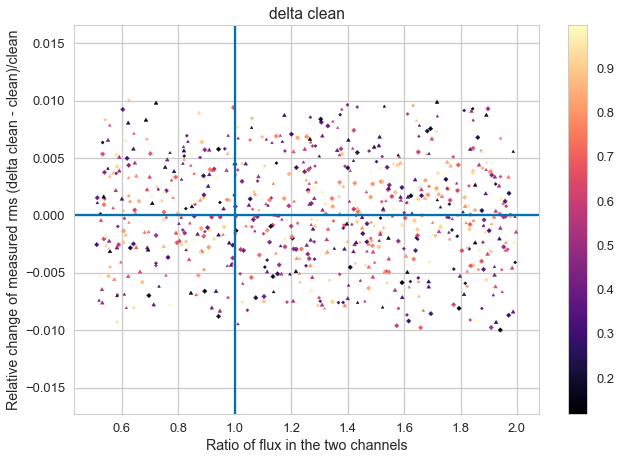

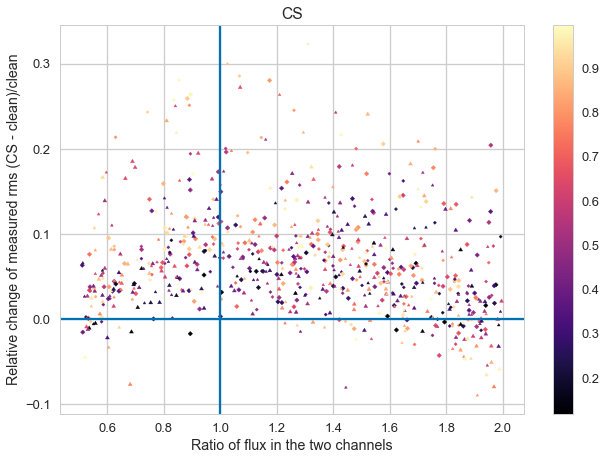

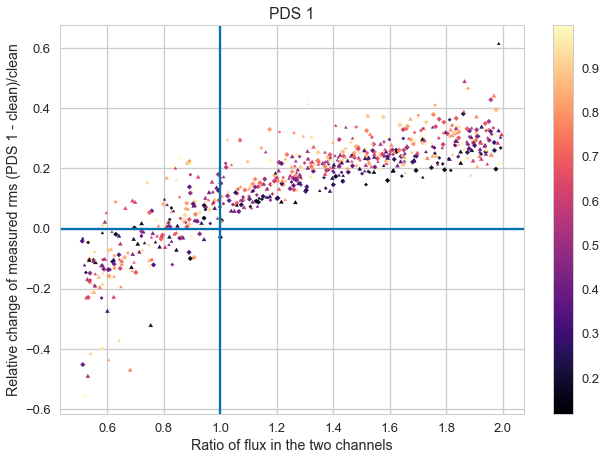

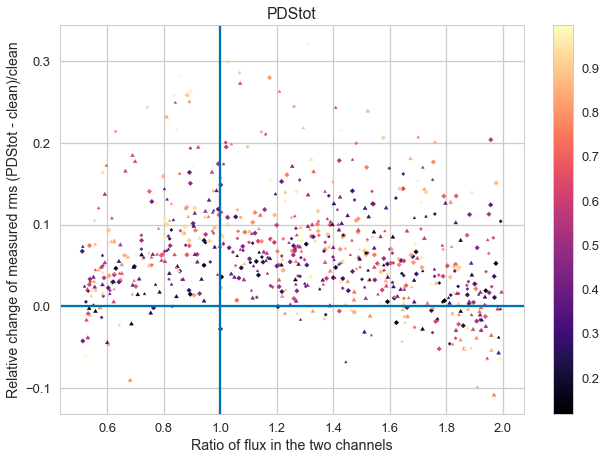

In [101]:
from plot_all_trials import *
plot_all('results_rn.csv')

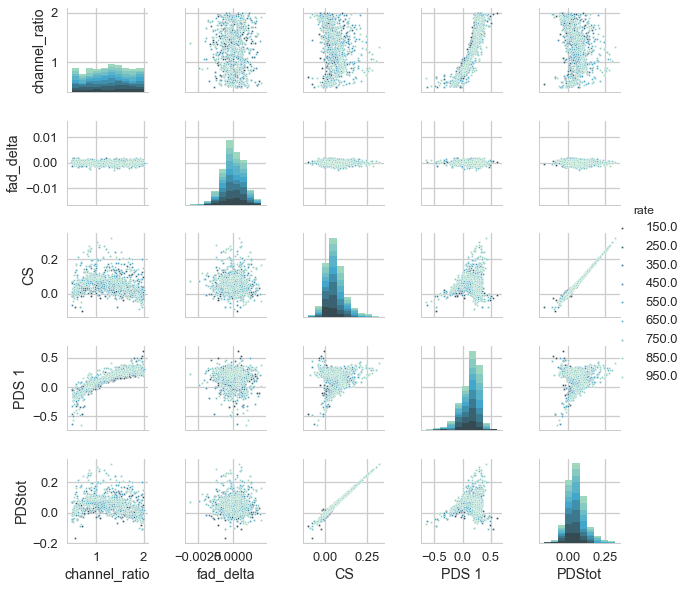

In [102]:
pairplot('results_rn.csv')

In [103]:
stats('results_rn.csv')

CS:
Mean _relative_ shift ((CS - clean)/clean) = (6.6 +- 6.2)%
PDStot:
Mean _relative_ shift ((PDStot - clean)/clean) = (6.4 +- 6.4)%
PDS 1:
Mean _relative_ shift ((PDS 1 - clean)/clean) = (14.7 +- 15.8)%


0.846358671999


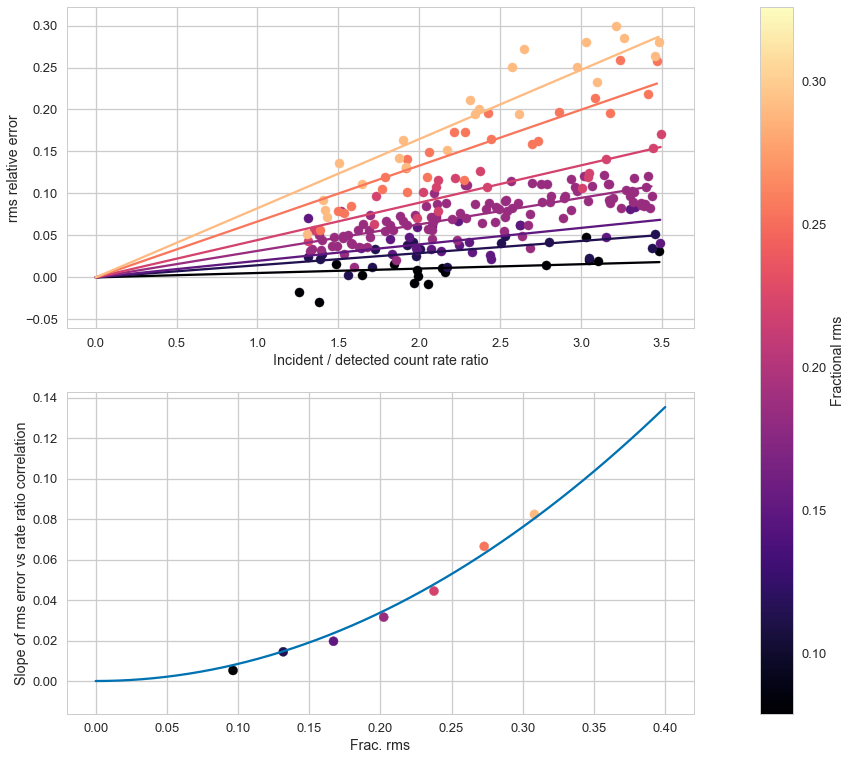

In [128]:
fit_incident_vs_delta('results_rn.csv')